In [1]:
# Parameters
SAMPLE = "HYA__24010b__20210813_384_PBMC_11_S9"
WORKFLOW_PARAMETERS = "{\"report_ipynb\":\"/src/bap/bin/bap_barcode_multiplet_report.ipynb\",\"bead_tag\":\"CB\",\"drop_tag\":\"DB\",\"minimum_barcode_fragments\":1000,\"barcode_whitelist\":\"\",\"minimum_jaccard_index\":0.02,\"nc_threshold\":6,\"regularize_threshold\":4,\"mapq\":30,\"max_insert\":2000,\"reference_genome\":\"hg38\",\"bedtools_genome\":\"\",\"blacklist_file\":\"\",\"tss_file\":\"\",\"mito_chromosome\":\"default\"}"


# VSN Pipelines: BAP multiplet pipeline report

Additional analyses and plots from the output of BAP (https://github.com/caleblareau/bap)

In [2]:
import pandas as pd
import numpy as np
import os
from collections import Counter
import itertools
import json

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
params = json.loads(WORKFLOW_PARAMETERS)

print(f"SAMPLE: {SAMPLE}")
print(f"BAP Parameters: {json.dumps(params, indent=4)}")

SAMPLE: HYA__24010b__20210813_384_PBMC_11_S9
BAP Parameters: {
    "report_ipynb": "/src/bap/bin/bap_barcode_multiplet_report.ipynb",
    "bead_tag": "CB",
    "drop_tag": "DB",
    "minimum_barcode_fragments": 1000,
    "barcode_whitelist": "",
    "minimum_jaccard_index": 0.02,
    "nc_threshold": 6,
    "regularize_threshold": 4,
    "mapq": 30,
    "max_insert": 2000,
    "reference_genome": "hg38",
    "bedtools_genome": "",
    "blacklist_file": "",
    "tss_file": "",
    "mito_chromosome": "default"
}


In [4]:
# read in data
f_bap_qc = SAMPLE+'.implicatedBarcodes.csv.gz'
f_bap_bct = SAMPLE+'.barcodeTranslate.tsv'
f_bap_nc = SAMPLE+'.NCsumstats.tsv'

bap_ib = pd.read_csv(f_bap_qc)
bap_bct = pd.read_csv(f_bap_bct, sep='\t', header=None, names=['barcode','bap_barcode'])
bap_nc = pd.read_csv(f_bap_nc, sep='\t')

## Overlap index

Plot the overlap scores, representing the pairwise similarity between each barcode.

In [5]:
# overlap index rank plot
def plot_overlap_rankplot(dat, label, ax):
    y = dat['jaccard_frag'].sort_values(ascending=False)
    ix = dat['jaccard_frag'][ dat['merged']==True ].idxmin()
    thr = dat.iloc[ix]['jaccard_frag']
    thrx = sum(dat['merged']==True)
    
    ax.scatter(x=range(y.shape[0]),
               y=y.values,
               s=4,
               edgecolors=None)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel('Jaccard index per barcode pair')
    ax.set_xlabel('Barcode pair rank')
    ax.axhline(thr, color='grey', linestyle='--')
    ax.text(0.01, 0.01, f" thr={round(thr,4)} ({thrx} barcode pairs)", ha='left', va='bottom' , transform=ax.transAxes, fontsize='x-small')
    ax.set_title(label)

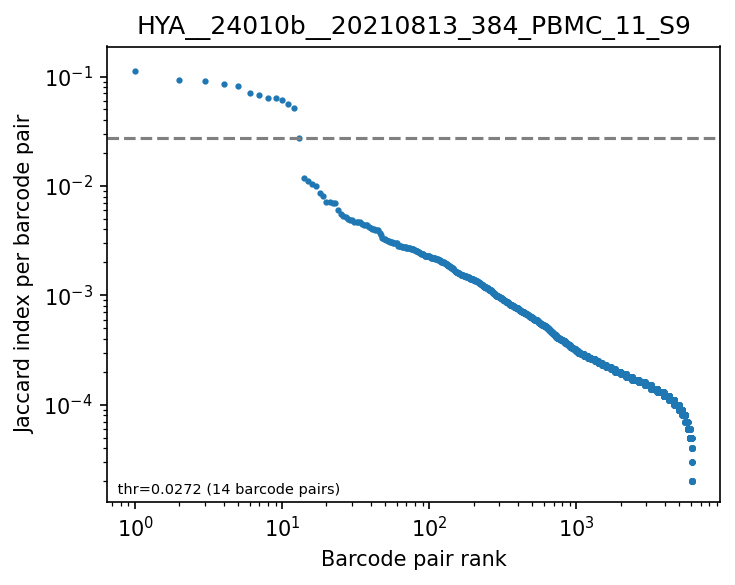

In [6]:
fig, ax = plt.subplots(1,1, figsize=(5,4), dpi=150 )

plot_overlap_rankplot(bap_ib, label=SAMPLE, ax=ax)
plt.tight_layout()

## Calculate restricted longest common subsequence (rLCS)

This approach follows the methods in:
* Lareau, C. A., Ma, S., Duarte, F. M. & Buenrostro, J. D. Inference and effects of barcode multiplets in droplet-based single-cell assays. Nature Communications 11, 1–9 (2020). https://doi.org/10.1038/s41467-020-14667-5

This is calculated by taking each set of barcodes identified as a multiplet, and calculating the overlap
and identifies two groups of droplet multiplets:
* **Physical multiplets** (multiple beads that are physically grouped together in a droplet)
  * Contains uniform barcodes (less than cutoff threshold on rLCS)
* **Complex beads** (assumed to be due to bead barcode synthesis errors)
  * Contain heterogenous barcodes (greater than a cutoff threshold on rLCS)

In [7]:
# calculate rLCS match score
def barcode_rle(a, b):
    assert len(a) == len(b)
    match_cnt = 0
    match_list = []
    for i in range(len(a)):
        
        if(a[i] == b[i]):
            match_cnt += 1
        else:
            match_list.append(match_cnt)
            match_cnt = 0
    match_list.append(match_cnt)
    return max(match_list)

In [8]:
rLCS_thr = 6

bap_bct['bap_N'] = [ x.split('_')[-1] for x in bap_bct['bap_barcode'] ]

multiplets = pd.DataFrame(
    bap_bct['bap_barcode'][bap_bct['bap_N']!='N01'].unique(), 
    columns=['bap_barcode'])
multiplets['bap_N'] = [ x.split('_')[-1] for x in multiplets['bap_barcode'] ]

bcs_scores = []
for i,m in enumerate(multiplets['bap_barcode']):
    bcs = bap_bct['barcode'][bap_bct['bap_barcode']==m]
    bcs_comb = list(itertools.combinations(bcs, 2))
    mean_scores = np.mean([ barcode_rle(x[0], x[1]) for x in bcs_comb ])
    bcs_scores.append(mean_scores)
multiplets['mean_rLCS'] = bcs_scores

# classify multiplet similarity by threshold
multiplets['multiplets_passing_rLCS_thr'] = multiplets['mean_rLCS']>=rLCS_thr
multiplets.dropna(inplace=True)

multiplets

,bap_barcode,bap_N,mean_rLCS,multiplets_passing_rLCS_thr
0,HYA__24010b__20210813_384_PBMC_11_S9_BC0294_N03,N03,10.333333,True
1,HYA__24010b__20210813_384_PBMC_11_S9_BC0641_N02,N02,10.000000,True
2,HYA__24010b__20210813_384_PBMC_11_S9_BC0678_N02,N02,10.000000,True
3,HYA__24010b__20210813_384_PBMC_11_S9_BC0727_N02,N02,10.000000,True
4,HYA__24010b__20210813_384_PBMC_11_S9_BC0830_N02,N02,10.000000,True
5,HYA__24010b__20210813_384_PBMC_11_S9_BC0879_N02,N02,11.000000,True
6,HYA__24010b__20210813_384_PBMC_11_S9_BC0891_N02,N02,11.000000,True
7,HYA__24010b__20210813_384_PBMC_11_S9_BC0921_N02,N02,10.000000,True
8,HYA__24010b__20210813_384_PBMC_11_S9_BC0955_N02,N02,10.000000,True
9,HYA__24010b__20210813_384_PBMC_11_S9_BC0966_N02,N02,10.000000,True


In [9]:
# number of beads per droplet
Counter(bap_bct['bap_N'])

Counter({'N01': 1101, 'N03': 3, 'N02': 22})

In [10]:
n_singlets = np.sum(bap_bct['bap_N']=='N01')

# multiplets with non barcode similarity (physical multiplets):
n_physical = sum([ 
    int(x.replace('N','')) 
    for x in multiplets['bap_N'][multiplets['multiplets_passing_rLCS_thr']==False] 
])

# multiplets with barcode similarity (complex multiplets):
n_complex = sum(multiplets['multiplets_passing_rLCS_thr'])

n_total = n_singlets + n_physical + n_complex

# n_complex / n_total # rate of bead heterogeneity

print(
    f"Number of singlets: {n_singlets}\n"
    f"Number of physical multiplets: {n_physical}\n"
    f"Number of complex multiplets: {n_complex}\n"
    f"Total: {n_total}\n"
    f"Rate of bead heterogeneity {round(n_complex/n_total,8)}"
)

Number of singlets: 1101
Number of physical multiplets: 2
Number of complex multiplets: 11
Total: 1114
Rate of bead heterogeneity 0.00987433


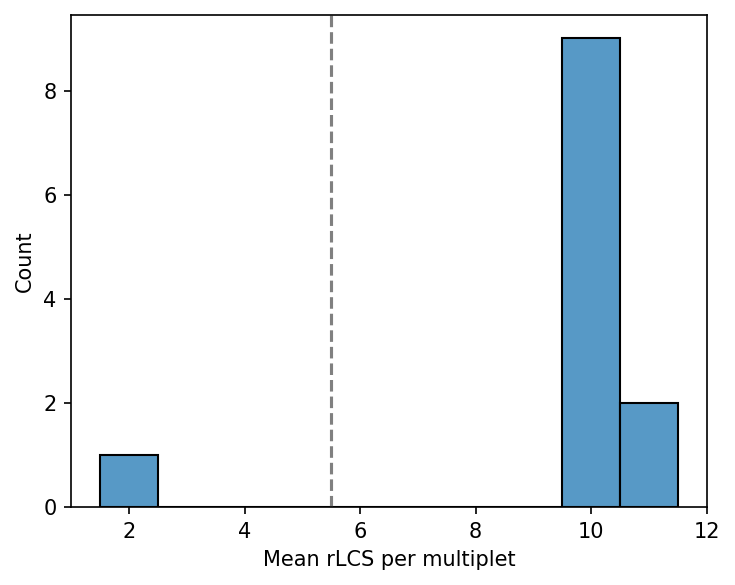

In [11]:
fig, ax = plt.subplots(1,1, figsize=(5,4), dpi=150)

sns.histplot(
    multiplets['mean_rLCS'],
    ax=ax,
    discrete=True)
ax.set_xlabel('Mean rLCS per multiplet')
ax.set_ylabel('Count')
ax.axvline(x=rLCS_thr-0.5, color='grey', linestyle='--')

plt.tight_layout()

## Barcode multiplets

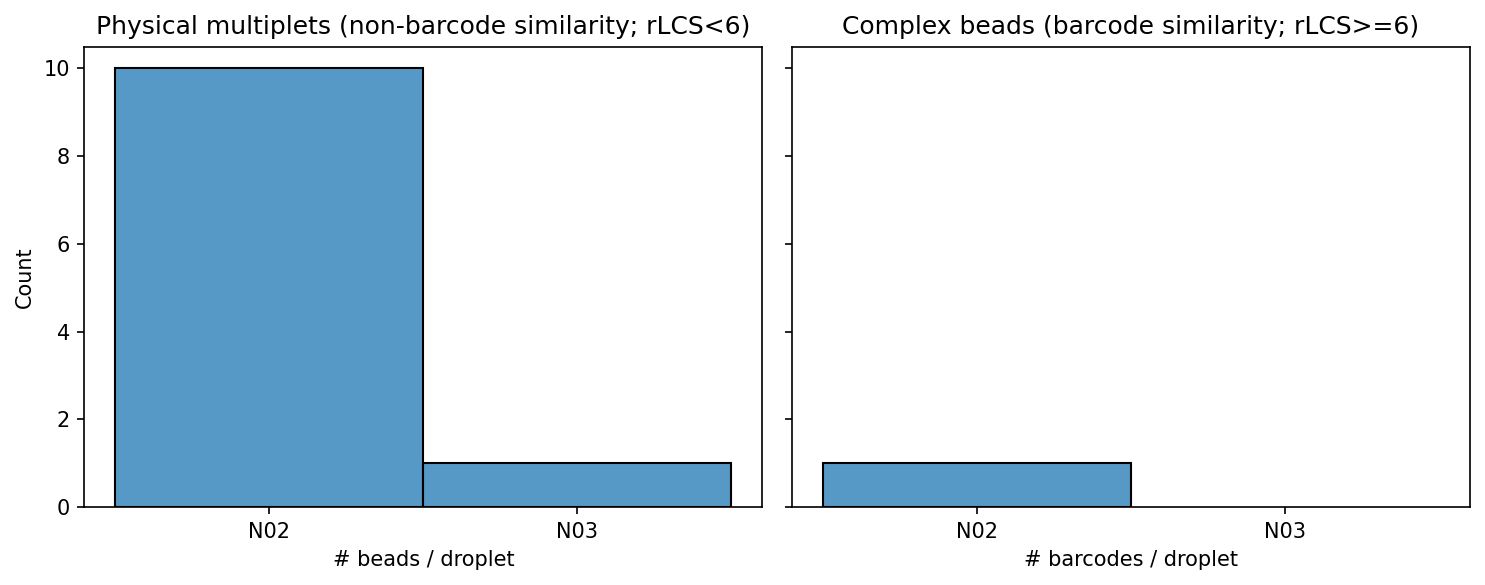

In [12]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4), dpi=150, sharex=True, sharey=True )

sns.histplot(
    multiplets['bap_N'][(multiplets['bap_N']!='N01') & (multiplets['multiplets_passing_rLCS_thr']==True)].sort_values(),
    ax=ax1,
    discrete=True)
ax1.set_title(f"Physical multiplets (non-barcode similarity; rLCS<{rLCS_thr})")
ax1.set_xlabel('# beads / droplet')
ax1.set_ylabel('Count')

sns.histplot(
    multiplets['bap_N'][(multiplets['bap_N']!='N01') & (multiplets['multiplets_passing_rLCS_thr']==False)].sort_values(),
    ax=ax2,
    discrete=True)
#ax1.set_title(SAMPLE)
ax2.set_title(f"Complex beads (barcode similarity; rLCS>={rLCS_thr})")
ax2.set_xlabel('# barcodes / droplet')
ax2.set_ylabel('Count')

plt.tight_layout()

## NC values

Look at the number of occurrences of a particular read across the experiment.

In [13]:
# plot NC values hist

def plot_bap_NC(dat, label, ax):
    p_ = sns.barplot(x='NC_value', y='NumberOfFragments', data=dat, ax=ax, color='grey')
    #ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('NC value')
    ax.set_ylabel('Number of fragments')
    ax.set_title(SAMPLE)
    ax.set_xbound(lower=-1)
    for ind, label in enumerate(p_.get_xticklabels()):
        if ind % 20 == 0:  # every 20th label is kept
            label.set_visible(True)
        else:
            label.set_visible(False)

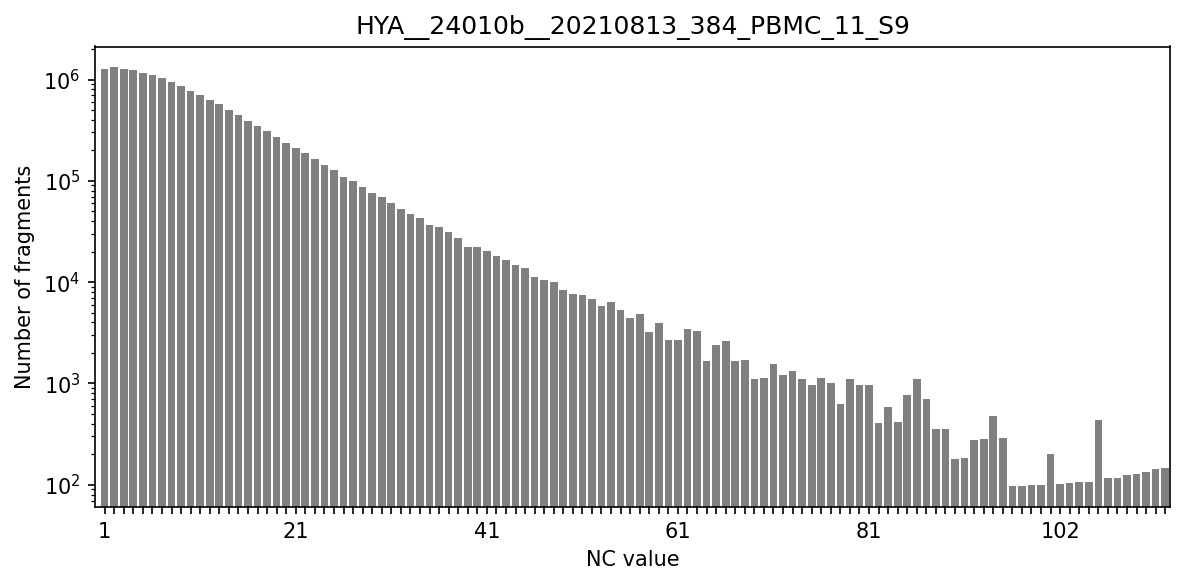

In [14]:
fig, ax = plt.subplots(1,1, figsize=(8,4), dpi=150 )

plot_bap_NC(bap_nc, label=SAMPLE, ax=ax)
plt.tight_layout()